In [2]:
import pandas as pd
import sys
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import re
import itertools
import datetime as dt
import sqlite3

# connect to folder for custom functions
root = Path.cwd().parent
vis_path = root / "src" / "visualizations" 
mod_path = root / "src" / "modelling" 
sys.path.append(str(vis_path))
sys.path.append(str(mod_path))

from read_articles import read
from plot_functions import plot_aini_series_subplots
from compute_extrema import compute_aini_extrema

In [3]:
# prepare paths
var_path = root / "data" / "processed" / "variables"
art_path = root / "data" / "processed" / "articles"
table_path = root / "reports" / "tables"

# load aini data
aini_custom = pd.read_csv(var_path / "binary_AINI_variables.csv")
aini_w0 = pd.read_csv(var_path / "w0_AINI_variables.csv")
aini_w1 = pd.read_csv(var_path / "w1_AINI_variables.csv")
aini_w2 =  pd.read_csv(var_path / "w2_AINI_variables.csv")


In [4]:
# create dataframes for visualizaions
normalized_AINI = pd.DataFrame()

# ensure sorting
aini_w0 = aini_w0.sort_values("date")
aini_w1 = aini_w1.sort_values("date")
aini_w2 = aini_w2.sort_values("date")
aini_custom = aini_custom.sort_values("date")

# compute extrema
merged, tidy, pivot, extrema = compute_aini_extrema(aini_w0,aini_w1,aini_w2,aini_custom)
merged

c:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\src\modelling\compute_extrema.py:69: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tidy.pivot_table(
c:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\src\modelling\compute_extrema.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tidy.groupby(["type", "date"])
c:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\src\modelling\compute_extrema.py:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,date,normalized_AINI_w0,simple_AINI_w0,EMA_02_w0,EMA_08_w0,normalized_AINI_growth_w0,normalized_AINI_w1,simple_AINI_w1,EMA_02_w1,EMA_08_w1,...,normalized_AINI_w2,simple_AINI_w2,EMA_02_w2,EMA_08_w2,normalized_AINI_growth_w2,normalized_AINI_custom,simple_AINI_custom,EMA_02_custom,EMA_08_custom,normalized_AINI_growth_custom
0,2023-04-01,0.000000,0,0.000000,0.000000,NaN,0.000000,0,0.000000,0.000000,...,0.0,0,0.000000,0.000000,NaN,0.000000,0,0.000000,0.000000,NaN
1,2023-04-02,0.000000,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,...,0.0,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000
2,2023-04-03,0.000000,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,...,0.0,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000
3,2023-04-04,0.000000,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,...,0.0,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000
4,2023-04-05,0.000000,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,...,0.0,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,2025-06-12,-0.055556,-2,0.038563,-0.024676,-0.160819,-0.027778,-1,0.028254,-0.000057,...,0.0,0,0.019938,0.006395,-0.026316,-0.055556,-2,-0.098190,-0.049539,-0.055556
777,2025-06-13,0.100000,3,0.050851,0.075065,0.155556,0.133333,4,0.049270,0.106655,...,0.1,3,0.035950,0.081279,0.100000,-0.166667,-5,-0.111886,-0.143241,-0.111111
778,2025-06-14,0.000000,0,0.040680,0.015013,-0.100000,0.000000,0,0.039416,0.021331,...,0.0,0,0.028760,0.016256,-0.100000,0.000000,0,-0.089509,-0.028648,0.166667
779,2025-06-15,0.000000,0,0.032544,0.003003,0.000000,0.000000,0,0.031533,0.004266,...,0.0,0,0.023008,0.003251,0.000000,0.000000,0,-0.071607,-0.005730,0.000000


Explore differences in min, max, mean and std.

In [5]:
def summarize_columns(df, exclude=["date"]):
    """Return mean, std, min, max for each numeric column in df (except exclude)."""
    results = []
    for col in df.columns:
        if col not in exclude:
            series = df[col]
            results.append({
                "variable": col,
                "mean": series.mean(),
                "std": series.std(),
                "min": series.min(),
                "max": series.max()
            })
    return pd.DataFrame(results)

# usage
stats_individual = summarize_columns(merged)
print(stats_individual)

                         variable          mean       std        min       max
0              normalized_AINI_w0 -8.229994e-03  0.070364  -0.636364  0.222222
1                  simple_AINI_w0 -2.227913e-01  2.421388 -32.000000  7.000000
2                       EMA_02_w0 -8.363339e-03  0.031709  -0.333738  0.067779
3                       EMA_08_w0 -8.230187e-03  0.061243  -0.624008  0.189112
4       normalized_AINI_growth_w0 -2.668805e-19  0.083317  -0.500000  0.713287
5              normalized_AINI_w1 -1.652568e-02  0.058105  -0.250000  0.200000
6                  simple_AINI_w1 -4.481434e-01  1.588076  -9.000000  7.000000
7                       EMA_02_w1 -1.685975e-02  0.024178  -0.110196  0.065226
8                       EMA_08_w1 -1.657717e-02  0.048613  -0.224539  0.160853
9       normalized_AINI_growth_w1  2.564103e-04  0.077262  -0.309524  0.291667
10             normalized_AINI_w2 -2.006468e-02  0.066418  -0.568182  0.200000
11                 simple_AINI_w2 -5.595391e-01  2.2

In [6]:
# write to csv
extrema.to_csv(table_path / "aini_extrema.csv")


In [7]:
# Convert to LaTeX with booktabs, tabular (single-page), wrapped in adjustbox
latex_table = extrema.to_latex(
    index=False,
    escape=True,
    column_format="l" + "c" * (len(extrema.columns) - 1),
    bold_rows=False
)

# Add booktabs spacing
latex_table = latex_table.replace("\\toprule", "\\toprule\n\\addlinespace")
latex_table = latex_table.replace("\\midrule", "\\midrule\n\\addlinespace")
latex_table = latex_table.replace("\\bottomrule", "\\addlinespace\n\\bottomrule")

# Wrap in table + adjustbox
latex_wrapped = (
    "\\begin{table}[!htbp]\n"
    "\\centering\n"
    "\\begin{adjustbox}{width=\\textwidth}\n"
    + latex_table +
    "\\end{adjustbox}\n"
    "\\caption{AINI extrema}\n"
    "\\label{tab:aini_extrema}\n"
    "\\end{table}\n"
)

# Save to file
output_path = table_path / "aini_extrema.tex"
with open(output_path, "w") as f:
    f.write(latex_wrapped)

Calculate weekly extrema (by calendar week)

In [8]:

# derive calendar week (ISO year + week number)
tidy["week"] = tidy["date"].dt.to_period("W").apply(lambda r: r.start_time)

# Count how often each min/max week occurs
counts_by_week = (
    tidy.groupby(["type", "week"])
        .size()
        .reset_index(name="count")
        .sort_values(["type", "count"], ascending=[True, False])
)

# subset n > 0
extrema_weekly = counts_by_week[counts_by_week["count"] > 0]

# collect variables for each week
week_dict = (
    tidy.groupby(["week"])["variable"]
    .apply(list)
    .to_dict()
)

# attach variables to each week
extrema_weekly["measure"] = extrema_weekly["week"].map(week_dict)

# bring into convenient format
extrema_weekly_clean = extrema_weekly.copy()

# week start (Monday)
week_start = extrema_weekly_clean["week"]
# week end (Sunday) = start + 6 days
week_end = week_start + pd.Timedelta(days=6)

# format as "dd.mm.yyyy - dd.mm.yyyy"
extrema_weekly_clean["week"] = (
    week_start.dt.strftime("%d.%m.%Y") + " - " + week_end.dt.strftime("%d.%m.%Y")
)

extrema_weekly_clean["type"] = extrema_weekly_clean["type"].replace({"min": "minimum", "max": "maximum"})
extrema_weekly_clean.rename(columns={"count": "n measures"}, inplace=True)

# save
extrema_weekly_clean.to_csv(table_path / "aini_weekly_extrema.csv", index=False)

C:\Users\PC\AppData\Local\Temp\ipykernel_22860\2517315283.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tidy.groupby(["type", "week"])
C:\Users\PC\AppData\Local\Temp\ipykernel_22860\2517315283.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extrema_weekly["measure"] = extrema_weekly["week"].map(week_dict)
C:\Users\PC\AppData\Local\Temp\ipykernel_22860\2517315283.py:38: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the

In [9]:
# Convert to LaTeX with booktabs, tabular (single-page), wrapped in adjustbox
latex_table = extrema_weekly_clean.to_latex(
    index=False,
    escape=True,
    column_format="l" + "c" * (len(extrema_weekly_clean.columns) - 1),
    bold_rows=False
)

# Add booktabs spacing
latex_table = latex_table.replace("\\toprule", "\\toprule\n\\addlinespace")
latex_table = latex_table.replace("\\midrule", "\\midrule\n\\addlinespace")
latex_table = latex_table.replace("\\bottomrule", "\\addlinespace\n\\bottomrule")

# Wrap in table + adjustbox
latex_wrapped = (
    "\\begin{table}[!htbp]\n"
    "\\centering\n"
    "\\begin{adjustbox}{width=\\textwidth}\n"
    + latex_table +
    "\\end{adjustbox}\n"
    "\\caption{AINI extrema}\n"
    "\\label{tab:aini_extrema}\n"
    "\\end{table}\n"
)

# Save to file
output_path = table_path / "aini_extrema_weekly.tex"
with open(output_path, "w") as f:
    f.write(latex_wrapped)

In [10]:
extrema.sort_values("n measures",ascending=False)

,type,date,n measures,measure
0,minimum,06.02.2025,8,"normalized_AINI_w0, EMA_02_w0, EMA_08_w0, norm..."
12,maximum,16.06.2025,6,"normalized_AINI_w1, EMA_02_w1, EMA_08_w1, norm..."
13,maximum,01.04.2023,4,"normalized_AINI_custom, simple_AINI_custom, EM..."
15,maximum,13.02.2025,3,"simple_AINI_w0, simple_AINI_w1, simple_AINI_w2"
14,maximum,21.06.2024,3,"normalized_AINI_w0, EMA_02_w0, EMA_08_w0"
1,minimum,04.02.2025,2,"simple_AINI_w0, simple_AINI_custom"
3,minimum,15.07.2023,1,normalized_AINI_custom
2,minimum,10.04.2023,1,normalized_AINI_w1
7,minimum,05.02.2025,1,simple_AINI_w2
6,minimum,21.11.2024,1,simple_AINI_w1


In [11]:
extrema_weekly_clean.sort_values("n measures",ascending=False)

,type,week,n measures,measure
7,minimum,03.02.2025 - 09.02.2025,11,"[normalized_AINI_w0, simple_AINI_w0, EMA_02_w0..."
19,maximum,16.06.2025 - 22.06.2025,6,"[normalized_AINI_w1, EMA_02_w1, EMA_08_w1, nor..."
10,maximum,27.03.2023 - 02.04.2023,4,"[normalized_AINI_custom, simple_AINI_custom, E..."
15,maximum,17.06.2024 - 23.06.2024,3,"[normalized_AINI_w0, EMA_02_w0, EMA_08_w0]"
18,maximum,10.02.2025 - 16.02.2025,3,"[simple_AINI_w0, simple_AINI_w1, simple_AINI_w2]"
1,minimum,10.04.2023 - 16.04.2023,1,[normalized_AINI_w1]
2,minimum,10.07.2023 - 16.07.2023,1,[normalized_AINI_custom]
3,minimum,07.08.2023 - 13.08.2023,1,[EMA_02_w1]
4,minimum,16.10.2023 - 22.10.2023,1,[EMA_08_w1]
6,minimum,18.11.2024 - 24.11.2024,1,[simple_AINI_w1]


Note: Min1 & Min2 in week with most Minima; 
Max1 is in week with most maxima, Max2 in second week with most maxima. 

load data with AINI predictions & compare with maxima and minima

In [12]:
# load & merge w1 data custom finbert data
c_df23 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2023_on_binary.csv")
c_df24 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2024_on_binary.csv")
c_df25 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2025_on_binary.csv")
c_df = pd.concat([c_df23,c_df24,c_df25]) 

# load & merge w0 data
w0_df23 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2023_windsize_0.csv")
w0_df24 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2024_windsize_0.csv")
w0_df25 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2025_windsize_0.csv")
w0_df = pd.concat([w0_df23,w0_df24,w0_df25]) 

# load & merge w1 data
w1_df23 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2023_windsize_1.csv")
w1_df24 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2024_windsize_1.csv")
w1_df25 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2025_windsize_1.csv")
w1_df = pd.concat([w1_df23,w1_df24,w1_df25]) 

# merge on normalized_aini_wo to identify relevant articles
w2_df23 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2023_windsize_2.csv")
w2_df24 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2024_windsize_2.csv")
w2_df25 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2025_windsize_2.csv")
w2_df = pd.concat([w2_df23,w2_df24,w2_df25]) 

# create df list 
aini_dfs = [c_df,w0_df,w1_df,w2_df]


In [13]:
# verify integrity
for df in aini_dfs:
    print(
        f"First entry: {df.date.min()} "
        f"\n last entry: {df.date.max()}, "
        f"\n n entries = {len(df)}, "
        f"\n n non-unique ids: {df['article_id'].duplicated().sum()}",
        f"Columns: {df.columns}"
    )

First entry: 2023-01-03 00:00:00 
 last entry: 2025-06-16 00:00:00, 
 n entries = 21886, 
 n non-unique ids: 1898 Columns: Index(['article_id', 'image_src', 'scanned_time', 'title', 'sub_title',
       'corpus', 'index_id', 'id', 'date', 'link', 'section', 'cleaned_corpus',
       'ai_window', 'predicted_label', 'predicted_class', 'ai_relevant',
       'sentiment_label', 'sentiment_score', 'hype_score'],
      dtype='object')
First entry: 2023-01-03 00:00:00 
 last entry: 2025-06-16 00:00:00, 
 n entries = 22904, 
 n non-unique ids: 1898 Columns: Index(['article_id', 'image_src', 'scanned_time', 'title', 'sub_title',
       'corpus', 'index_id', 'id', 'date', 'link', 'section', 'cleaned_corpus',
       'text', 'ai_window', 'ai_relevant', 'sentiment_label',
       'sentiment_score', 'hype_score'],
      dtype='object')
First entry: 2023-01-03 00:00:00 
 last entry: 2025-06-16 00:00:00, 
 n entries = 22904, 
 n non-unique ids: 1898 Columns: Index(['article_id', 'image_src', 'scanned_time

In [14]:
# subset for relevant columns
rel_col = ["article_id","sentiment_label","sentiment_score","hype_score"]
clean_df = []

for df in aini_dfs:
    df = df[rel_col].copy()
    clean_df.append(df)
    
c_df_sub,w0_df_sub,w1_df_sub,w2_df_sub = clean_df
c_df_sub

,article_id,sentiment_label,sentiment_score,hype_score
0,36,neutral,0.000000,0
1,39,neutral,0.000000,0
2,87,neutral,0.000000,0
3,102,neutral,0.000000,0
4,111,neutral,0.000000,0
...,...,...,...,...
4055,4120,neutral,0.000000,0
4056,4121,neutral,0.000000,0
4057,4122,neutral,0.000000,0
4058,4123,neutral,0.000000,0


In [15]:
# list of DB paths
db_files = [
    art_path / "articlesWSJ_clean_2023.db",
    art_path / "articlesWSJ_clean_2024.db",
    art_path / "articlesWSJ_clean_2025.db",
]

dfs = []
for db in db_files:
    with sqlite3.connect(db) as conn:

        # read data base into data frame
        df = pd.read_sql("SELECT * FROM article", conn)
        dfs.append(df)

# combine into one DataFrame
all_articles = pd.concat(dfs, ignore_index=True)

# verify integrity
print(
    f"First entry: {all_articles.date.min()} "
    f"\n last entry: {all_articles.date.max()}, "
    f"\n n entries = {len(all_articles)}, "
    f"\n n non-unique ids: {all_articles['article_id'].duplicated().sum()}",
    f"Columns: {all_articles.columns}"
)

First entry: 2023-01-03 00:00:00 
 last entry: 2025-06-16 00:00:00, 
 n entries = 22904, 
 n non-unique ids: 1898 Columns: Index(['article_id', 'image_src', 'scanned_time', 'title', 'sub_title',
       'corpus', 'index_id', 'id', 'date', 'link', 'section',
       'cleaned_corpus'],
      dtype='object')


In [16]:
# harmonize key dtype
all_articles["article_id"] = all_articles["article_id"].astype(str)
c_df_sub["article_id"]  = c_df_sub["article_id"].astype(str)
w0_df_sub["article_id"] = w0_df_sub["article_id"].astype(str)
w1_df_sub["article_id"] = w1_df_sub["article_id"].astype(str)
w2_df_sub["article_id"] = w2_df_sub["article_id"].astype(str)

# start from base
complete_df = all_articles.copy()

# merge step by step with suffixes
complete_df = complete_df.merge(c_df_sub,  on="article_id", how="left", suffixes=("", "_c"))
complete_df = complete_df.merge(w0_df_sub, on="article_id", how="left", suffixes=("", "_w0"))
complete_df = complete_df.merge(w1_df_sub, on="article_id", how="left", suffixes=("", "_w1"))
complete_df = complete_df.merge(w2_df_sub, on="article_id", how="left", suffixes=("", "_w2"))


# verify integrity
print(
    f"First entry: {complete_df.date.min()} "
    f"\n last entry: {complete_df.date.max()}, "
    f"\n n entries = {len(complete_df)}, "
    f"\n n non-unique ids: {complete_df['article_id'].duplicated().sum()}",
    f"Columns: {w0_df.columns}"
)
c_df_sub

First entry: 2023-01-03 00:00:00 
 last entry: 2025-06-16 00:00:00, 
 n entries = 79844, 
 n non-unique ids: 58838 Columns: Index(['article_id', 'image_src', 'scanned_time', 'title', 'sub_title',
       'corpus', 'index_id', 'id', 'date', 'link', 'section', 'cleaned_corpus',
       'text', 'ai_window', 'ai_relevant', 'sentiment_label',
       'sentiment_score', 'hype_score'],
      dtype='object')


,article_id,sentiment_label,sentiment_score,hype_score
0,36,neutral,0.000000,0
1,39,neutral,0.000000,0
2,87,neutral,0.000000,0
3,102,neutral,0.000000,0
4,111,neutral,0.000000,0
...,...,...,...,...
4055,4120,neutral,0.000000,0
4056,4121,neutral,0.000000,0
4057,4122,neutral,0.000000,0
4058,4123,neutral,0.000000,0


In [17]:
# ensure format in date col 
complete_df["dates"] = pd.to_datetime(complete_df["date"])

# define minima
min_1 = pd.Timestamp("2025-02-06") # n=8
min_2 = pd.Timestamp("2025-02-04") # n=2

# define maxima
max_1 = pd.Timestamp("2025-06-16") # n=6
max_2 = pd.Timestamp("2025-04-01")  # n=4

# subset original data extrema, minima
articles_min1 = complete_df[complete_df["dates"] == min_1] 
articles_min2 = complete_df[complete_df["dates"] == min_2]

# subset original data extrema, maxmima
articles_max1 = complete_df[complete_df["dates"] == max_1] 
articles_max2 = complete_df[complete_df["dates"] == max_2] 

# investigate structure
articles_max1

,article_id,image_src,scanned_time,title,sub_title,corpus,index_id,id,date,link,...,sentiment_label_w0,sentiment_score_w0,hype_score_w0,sentiment_label_w1,sentiment_score_w1,hype_score_w1,sentiment_label_w2,sentiment_score_w2,hype_score_w2,dates
79634,4110,,2025-06-19 01:22:51,Victoria’s Secret Is Under Mounting Pressure F...,Barington plans to push the lingerie retailer ...,BUSINESS\nRETAIL\nVictoria’s Secret Is Under M...,4896,4896,2025-06-16 00:00:00,https://www.wsj.com/business/retail/victorias-...,...,neutral,0.000000,0,neutral,0.000000,0,neutral,0.000000,0,2025-06-16
79635,4110,,2025-06-19 01:22:51,Victoria’s Secret Is Under Mounting Pressure F...,Barington plans to push the lingerie retailer ...,BUSINESS\nRETAIL\nVictoria’s Secret Is Under M...,4896,4896,2025-06-16 00:00:00,https://www.wsj.com/business/retail/victorias-...,...,neutral,0.000000,0,neutral,0.000000,0,neutral,0.000000,0,2025-06-16
79636,4110,,2025-06-19 01:22:51,Victoria’s Secret Is Under Mounting Pressure F...,Barington plans to push the lingerie retailer ...,BUSINESS\nRETAIL\nVictoria’s Secret Is Under M...,4896,4896,2025-06-16 00:00:00,https://www.wsj.com/business/retail/victorias-...,...,neutral,0.000000,0,neutral,0.000000,0,neutral,0.000000,0,2025-06-16
79637,4110,,2025-06-19 01:22:51,Victoria’s Secret Is Under Mounting Pressure F...,Barington plans to push the lingerie retailer ...,BUSINESS\nRETAIL\nVictoria’s Secret Is Under M...,4896,4896,2025-06-16 00:00:00,https://www.wsj.com/business/retail/victorias-...,...,neutral,0.000000,0,neutral,0.000000,0,neutral,0.000000,0,2025-06-16
79638,4110,,2025-06-19 01:22:51,Victoria’s Secret Is Under Mounting Pressure F...,Barington plans to push the lingerie retailer ...,BUSINESS\nRETAIL\nVictoria’s Secret Is Under M...,4896,4896,2025-06-16 00:00:00,https://www.wsj.com/business/retail/victorias-...,...,neutral,0.000000,0,neutral,0.000000,0,neutral,0.000000,0,2025-06-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79839,4124,,2025-06-19 01:24:20,Amazon to Invest Nearly $13 Billion in Data Ce...,The plan marks Australia’s largest publicly-an...,TECHNOLOGY\nAmazon to Invest Nearly $13 Billio...,4910,4910,2025-06-16 00:00:00,https://www.wsj.com/tech/amazon-to-invest-near...,...,neutral,0.000000,0,positive,0.825307,1,positive,0.772042,1,2025-06-16
79840,4124,,2025-06-19 01:24:20,Amazon to Invest Nearly $13 Billion in Data Ce...,The plan marks Australia’s largest publicly-an...,TECHNOLOGY\nAmazon to Invest Nearly $13 Billio...,4910,4910,2025-06-16 00:00:00,https://www.wsj.com/tech/amazon-to-invest-near...,...,neutral,0.632564,0,neutral,0.000000,0,neutral,0.000000,0,2025-06-16
79841,4124,,2025-06-19 01:24:20,Amazon to Invest Nearly $13 Billion in Data Ce...,The plan marks Australia’s largest publicly-an...,TECHNOLOGY\nAmazon to Invest Nearly $13 Billio...,4910,4910,2025-06-16 00:00:00,https://www.wsj.com/tech/amazon-to-invest-near...,...,neutral,0.632564,0,neutral,0.000000,0,positive,0.772042,1,2025-06-16
79842,4124,,2025-06-19 01:24:20,Amazon to Invest Nearly $13 Billion in Data Ce...,The plan marks Australia’s largest publicly-an...,TECHNOLOGY\nAmazon to Invest Nearly $13 Billio...,4910,4910,2025-06-16 00:00:00,https://www.wsj.com/tech/amazon-to-invest-near...,...,neutral,0.632564,0,positive,0.825307,1,neutral,0.000000,0,2025-06-16


In [18]:
# investigate 06.02.2025; min 1
read(articles_min1)

c:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\src\visualizations\read_articles.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)
c:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\src\visualizations\read_articles.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)
c:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\src\visualizations\read_articles.py:49: 

Title   : Tech Giants Double Down on Their Massive AI Spending
Date    : 2025-02-06 00:00:00
Section : tech
Scores  : hype_score=-1, hype_score_w0=0, hype_score_w1=0, hype_score_w2=0
--------------------------------------------------------------------------------
Amazon,. Google,. Microsoft and. Meta pour billions into artificial intelligence, undeterred by.
DeepSeek's rise 2 min. Capital spending, quarterly 75 50 25 0 '21 '22 '23 '24. Note. Data in this
chart and those below reflect purchases of property and equipment. This chart shows data for each
calendar quarter. Microsoft's fiscal year ends. June 30. Source the companies. Feb. 6, 1005 pm. ET.
Tech giants projected tens of billions of dollars in increased investment this year and sent a stark
message about their plans for. AI. We're just getting started. The four biggest spenders on the data
centers that power artificial-intelligence systems all said in recent days that they would jack up
investments further in after record outlay

In [23]:
articles_min1

,article_id,image_src,scanned_time,title,sub_title,corpus,index_id,id,date,link,...,sentiment_label_w0,sentiment_score_w0,hype_score_w0,sentiment_label_w1,sentiment_score_w1,hype_score_w1,sentiment_label_w2,sentiment_score_w2,hype_score_w2,dates
54036,1056,,2025-06-18 18:18:47,Tech Giants Double Down on Their Massive AI Sp...,"Amazon, Google, Microsoft and Meta pour billio...",TECHNOLOGY\nARTIFICIAL INTELLIGENCE\nFollow\nT...,1056,1056,2025-02-06 00:00:00,https://www.wsj.com/tech/ai/tech-giants-double...,...,neutral,0.000000,0,neutral,0.000000,0,neutral,0.000000,0,2025-02-06
54037,1056,,2025-06-18 18:18:47,Tech Giants Double Down on Their Massive AI Sp...,"Amazon, Google, Microsoft and Meta pour billio...",TECHNOLOGY\nARTIFICIAL INTELLIGENCE\nFollow\nT...,1056,1056,2025-02-06 00:00:00,https://www.wsj.com/tech/ai/tech-giants-double...,...,neutral,0.000000,0,neutral,0.000000,0,neutral,0.820373,0,2025-02-06
54038,1056,,2025-06-18 18:18:47,Tech Giants Double Down on Their Massive AI Sp...,"Amazon, Google, Microsoft and Meta pour billio...",TECHNOLOGY\nARTIFICIAL INTELLIGENCE\nFollow\nT...,1056,1056,2025-02-06 00:00:00,https://www.wsj.com/tech/ai/tech-giants-double...,...,neutral,0.000000,0,neutral,0.923038,0,neutral,0.000000,0,2025-02-06
54039,1056,,2025-06-18 18:18:47,Tech Giants Double Down on Their Massive AI Sp...,"Amazon, Google, Microsoft and Meta pour billio...",TECHNOLOGY\nARTIFICIAL INTELLIGENCE\nFollow\nT...,1056,1056,2025-02-06 00:00:00,https://www.wsj.com/tech/ai/tech-giants-double...,...,neutral,0.000000,0,neutral,0.923038,0,neutral,0.820373,0,2025-02-06
54040,1056,,2025-06-18 18:18:47,Tech Giants Double Down on Their Massive AI Sp...,"Amazon, Google, Microsoft and Meta pour billio...",TECHNOLOGY\nARTIFICIAL INTELLIGENCE\nFollow\nT...,1056,1056,2025-02-06 00:00:00,https://www.wsj.com/tech/ai/tech-giants-double...,...,neutral,0.900646,0,neutral,0.000000,0,neutral,0.000000,0,2025-02-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54705,1099,,2025-06-18 18:23:32,Steve Bannon on Trump’s ‘Outside the Universe’...,Former Trump adviser speaks with The Wall Stre...,POLITICS\nPOLICY\nSteve Bannon on Trump’s ‘Out...,1099,1099,2025-02-06 00:00:00,https://www.wsj.com/politics/policy/steve-bann...,...,neutral,0.000000,0,neutral,0.000000,0,neutral,0.000000,0,2025-02-06
54706,1099,,2025-06-18 18:23:32,Steve Bannon on Trump’s ‘Outside the Universe’...,Former Trump adviser speaks with The Wall Stre...,POLITICS\nPOLICY\nSteve Bannon on Trump’s ‘Out...,1099,1099,2025-02-06 00:00:00,https://www.wsj.com/politics/policy/steve-bann...,...,neutral,0.000000,0,neutral,0.000000,0,neutral,0.000000,0,2025-02-06
54707,1099,,2025-06-18 18:23:32,Steve Bannon on Trump’s ‘Outside the Universe’...,Former Trump adviser speaks with The Wall Stre...,POLITICS\nPOLICY\nSteve Bannon on Trump’s ‘Out...,1099,1099,2025-02-06 00:00:00,https://www.wsj.com/politics/policy/steve-bann...,...,neutral,0.000000,0,neutral,0.000000,0,neutral,0.000000,0,2025-02-06
54708,1099,,2025-06-18 18:23:32,Steve Bannon on Trump’s ‘Outside the Universe’...,Former Trump adviser speaks with The Wall Stre...,POLITICS\nPOLICY\nSteve Bannon on Trump’s ‘Out...,1099,1099,2025-02-06 00:00:00,https://www.wsj.com/politics/policy/steve-bann...,...,neutral,0.000000,0,neutral,0.000000,0,neutral,0.000000,0,2025-02-06


In [19]:
# investigate 16.06.2025; max 1 according to ['normalized_AINI_w1', 'normalized_AINI_w2', 'EMA_02_w1', 'EMA_02_w2', 'EMA_08_w1', 'EMA_08_w2']
articles_max1

,article_id,image_src,scanned_time,title,sub_title,corpus,index_id,id,date,link,...,sentiment_label_w0,sentiment_score_w0,hype_score_w0,sentiment_label_w1,sentiment_score_w1,hype_score_w1,sentiment_label_w2,sentiment_score_w2,hype_score_w2,dates
79634,4110,,2025-06-19 01:22:51,Victoria’s Secret Is Under Mounting Pressure F...,Barington plans to push the lingerie retailer ...,BUSINESS\nRETAIL\nVictoria’s Secret Is Under M...,4896,4896,2025-06-16 00:00:00,https://www.wsj.com/business/retail/victorias-...,...,neutral,0.000000,0,neutral,0.000000,0,neutral,0.000000,0,2025-06-16
79635,4110,,2025-06-19 01:22:51,Victoria’s Secret Is Under Mounting Pressure F...,Barington plans to push the lingerie retailer ...,BUSINESS\nRETAIL\nVictoria’s Secret Is Under M...,4896,4896,2025-06-16 00:00:00,https://www.wsj.com/business/retail/victorias-...,...,neutral,0.000000,0,neutral,0.000000,0,neutral,0.000000,0,2025-06-16
79636,4110,,2025-06-19 01:22:51,Victoria’s Secret Is Under Mounting Pressure F...,Barington plans to push the lingerie retailer ...,BUSINESS\nRETAIL\nVictoria’s Secret Is Under M...,4896,4896,2025-06-16 00:00:00,https://www.wsj.com/business/retail/victorias-...,...,neutral,0.000000,0,neutral,0.000000,0,neutral,0.000000,0,2025-06-16
79637,4110,,2025-06-19 01:22:51,Victoria’s Secret Is Under Mounting Pressure F...,Barington plans to push the lingerie retailer ...,BUSINESS\nRETAIL\nVictoria’s Secret Is Under M...,4896,4896,2025-06-16 00:00:00,https://www.wsj.com/business/retail/victorias-...,...,neutral,0.000000,0,neutral,0.000000,0,neutral,0.000000,0,2025-06-16
79638,4110,,2025-06-19 01:22:51,Victoria’s Secret Is Under Mounting Pressure F...,Barington plans to push the lingerie retailer ...,BUSINESS\nRETAIL\nVictoria’s Secret Is Under M...,4896,4896,2025-06-16 00:00:00,https://www.wsj.com/business/retail/victorias-...,...,neutral,0.000000,0,neutral,0.000000,0,neutral,0.000000,0,2025-06-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79839,4124,,2025-06-19 01:24:20,Amazon to Invest Nearly $13 Billion in Data Ce...,The plan marks Australia’s largest publicly-an...,TECHNOLOGY\nAmazon to Invest Nearly $13 Billio...,4910,4910,2025-06-16 00:00:00,https://www.wsj.com/tech/amazon-to-invest-near...,...,neutral,0.000000,0,positive,0.825307,1,positive,0.772042,1,2025-06-16
79840,4124,,2025-06-19 01:24:20,Amazon to Invest Nearly $13 Billion in Data Ce...,The plan marks Australia’s largest publicly-an...,TECHNOLOGY\nAmazon to Invest Nearly $13 Billio...,4910,4910,2025-06-16 00:00:00,https://www.wsj.com/tech/amazon-to-invest-near...,...,neutral,0.632564,0,neutral,0.000000,0,neutral,0.000000,0,2025-06-16
79841,4124,,2025-06-19 01:24:20,Amazon to Invest Nearly $13 Billion in Data Ce...,The plan marks Australia’s largest publicly-an...,TECHNOLOGY\nAmazon to Invest Nearly $13 Billio...,4910,4910,2025-06-16 00:00:00,https://www.wsj.com/tech/amazon-to-invest-near...,...,neutral,0.632564,0,neutral,0.000000,0,positive,0.772042,1,2025-06-16
79842,4124,,2025-06-19 01:24:20,Amazon to Invest Nearly $13 Billion in Data Ce...,The plan marks Australia’s largest publicly-an...,TECHNOLOGY\nAmazon to Invest Nearly $13 Billio...,4910,4910,2025-06-16 00:00:00,https://www.wsj.com/tech/amazon-to-invest-near...,...,neutral,0.632564,0,positive,0.825307,1,neutral,0.000000,0,2025-06-16


In [20]:
# investigate 01.04.2023; max 2 according to normalized_AINI_custom, simple_AINI_custom, EMA_02_custom, EMA_08_custom
articles_max1

,article_id,image_src,scanned_time,title,sub_title,corpus,index_id,id,date,link,...,sentiment_label_w0,sentiment_score_w0,hype_score_w0,sentiment_label_w1,sentiment_score_w1,hype_score_w1,sentiment_label_w2,sentiment_score_w2,hype_score_w2,dates
79634,4110,,2025-06-19 01:22:51,Victoria’s Secret Is Under Mounting Pressure F...,Barington plans to push the lingerie retailer ...,BUSINESS\nRETAIL\nVictoria’s Secret Is Under M...,4896,4896,2025-06-16 00:00:00,https://www.wsj.com/business/retail/victorias-...,...,neutral,0.000000,0,neutral,0.000000,0,neutral,0.000000,0,2025-06-16
79635,4110,,2025-06-19 01:22:51,Victoria’s Secret Is Under Mounting Pressure F...,Barington plans to push the lingerie retailer ...,BUSINESS\nRETAIL\nVictoria’s Secret Is Under M...,4896,4896,2025-06-16 00:00:00,https://www.wsj.com/business/retail/victorias-...,...,neutral,0.000000,0,neutral,0.000000,0,neutral,0.000000,0,2025-06-16
79636,4110,,2025-06-19 01:22:51,Victoria’s Secret Is Under Mounting Pressure F...,Barington plans to push the lingerie retailer ...,BUSINESS\nRETAIL\nVictoria’s Secret Is Under M...,4896,4896,2025-06-16 00:00:00,https://www.wsj.com/business/retail/victorias-...,...,neutral,0.000000,0,neutral,0.000000,0,neutral,0.000000,0,2025-06-16
79637,4110,,2025-06-19 01:22:51,Victoria’s Secret Is Under Mounting Pressure F...,Barington plans to push the lingerie retailer ...,BUSINESS\nRETAIL\nVictoria’s Secret Is Under M...,4896,4896,2025-06-16 00:00:00,https://www.wsj.com/business/retail/victorias-...,...,neutral,0.000000,0,neutral,0.000000,0,neutral,0.000000,0,2025-06-16
79638,4110,,2025-06-19 01:22:51,Victoria’s Secret Is Under Mounting Pressure F...,Barington plans to push the lingerie retailer ...,BUSINESS\nRETAIL\nVictoria’s Secret Is Under M...,4896,4896,2025-06-16 00:00:00,https://www.wsj.com/business/retail/victorias-...,...,neutral,0.000000,0,neutral,0.000000,0,neutral,0.000000,0,2025-06-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79839,4124,,2025-06-19 01:24:20,Amazon to Invest Nearly $13 Billion in Data Ce...,The plan marks Australia’s largest publicly-an...,TECHNOLOGY\nAmazon to Invest Nearly $13 Billio...,4910,4910,2025-06-16 00:00:00,https://www.wsj.com/tech/amazon-to-invest-near...,...,neutral,0.000000,0,positive,0.825307,1,positive,0.772042,1,2025-06-16
79840,4124,,2025-06-19 01:24:20,Amazon to Invest Nearly $13 Billion in Data Ce...,The plan marks Australia’s largest publicly-an...,TECHNOLOGY\nAmazon to Invest Nearly $13 Billio...,4910,4910,2025-06-16 00:00:00,https://www.wsj.com/tech/amazon-to-invest-near...,...,neutral,0.632564,0,neutral,0.000000,0,neutral,0.000000,0,2025-06-16
79841,4124,,2025-06-19 01:24:20,Amazon to Invest Nearly $13 Billion in Data Ce...,The plan marks Australia’s largest publicly-an...,TECHNOLOGY\nAmazon to Invest Nearly $13 Billio...,4910,4910,2025-06-16 00:00:00,https://www.wsj.com/tech/amazon-to-invest-near...,...,neutral,0.632564,0,neutral,0.000000,0,positive,0.772042,1,2025-06-16
79842,4124,,2025-06-19 01:24:20,Amazon to Invest Nearly $13 Billion in Data Ce...,The plan marks Australia’s largest publicly-an...,TECHNOLOGY\nAmazon to Invest Nearly $13 Billio...,4910,4910,2025-06-16 00:00:00,https://www.wsj.com/tech/amazon-to-invest-near...,...,neutral,0.632564,0,positive,0.825307,1,neutral,0.000000,0,2025-06-16


In [21]:
# ensure datetime type
complete_df["date"] = pd.to_datetime(complete_df["date"], errors="coerce")

# subsets per year
df_2023 = complete_df[complete_df["date"].dt.year == 2023]
df_2024 = complete_df[complete_df["date"].dt.year == 2024]
df_2025 = complete_df[complete_df["date"].dt.year == 2025]

Investigate AINI by year

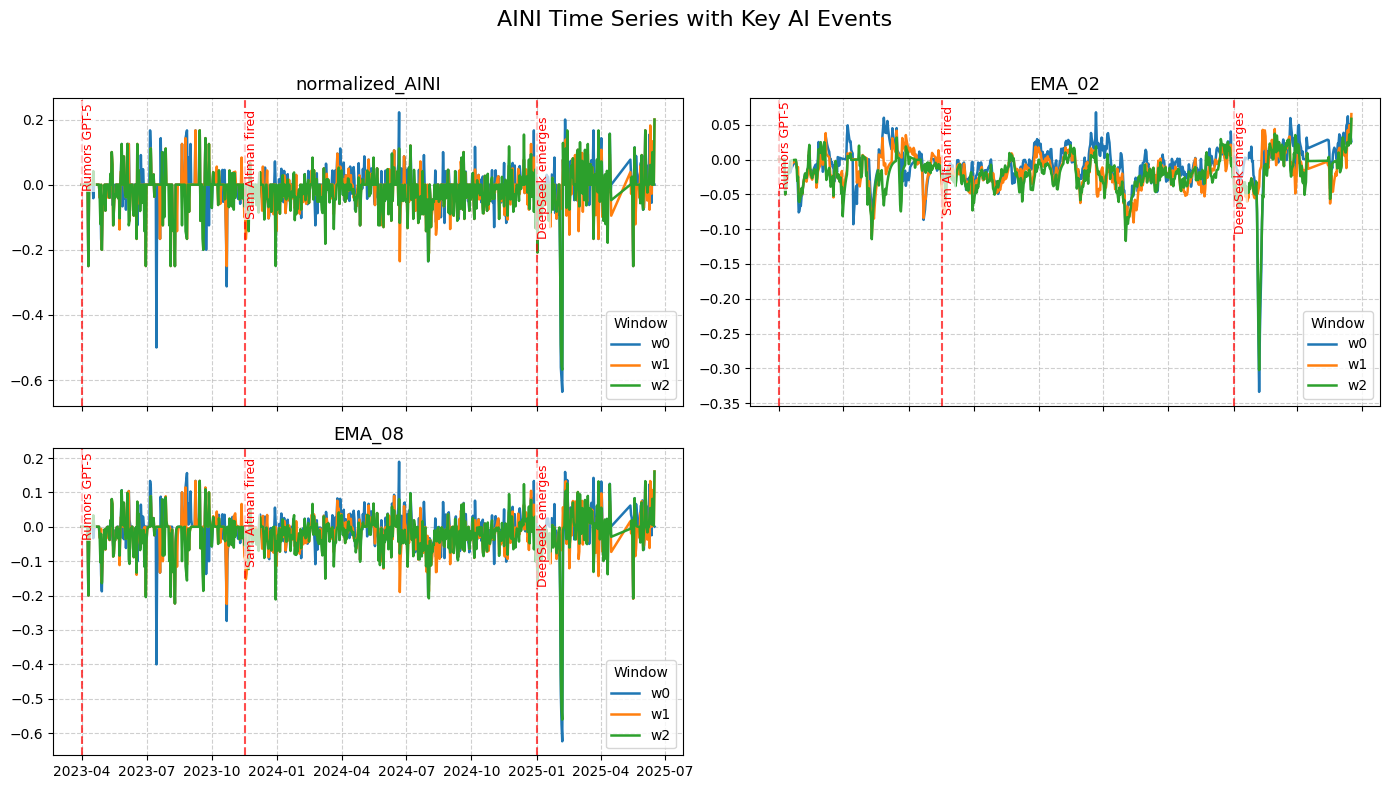

In [22]:
plot_aini_series_subplots(merged)